# Task table example

This example shows how to load a task table to the Proteus instrument in PXIe form factor

In [5]:
import os
import sys
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
#from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst

In [8]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

## Open communication to instrument with LAN

In [39]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = 'TCPIP::192.168.0.62::5025::SOCKET'

inst = TEVisaInst(inst_addr)

resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp)


connected to: Tabor Electronics,P9484M,000002210203,1.119.0


## Connect to instrument and initialize

In [15]:
# The paranoia-level is either 
# low (0), normal (1) or debug (2)
paranoia_level = 2

print ('Reset instrument ..')

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

# Get the DAC mode (8 bits or 16 bits)
inst.send_scpi_query(':SYST:INF:DAC?')
print(resp)

if resp == 'M0':
    dac_mode = 16 
else:
    dac_mode = 8
    
# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

if model_name.startswith('P948'):
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 1
elif model_name.startswith('P908'):
    bpp = 1
    max_dac = 255
    wpt_type = np.uint8
    offset_factor = 1
else:
    bpp = 2
    max_dac = 65535
    wpt_type = np.uint16
    offset_factor = 2
    
half_dac = max_dac / 2.0
    

print('DAC mode {0} bits'.format(dac_mode))
# Get number of channels
resp =inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.send_scpi_query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

max_dac = 2 ** dac_mode - 1
half_dac = max_dac // 2.0

print('Done')

Reset instrument ..


NameError: name 'inst' is not defined

## Prepare wave-data and markers-data for 12 segments

Prepare three types of waveforms, sine, triangle and square with varying number of cycles. 
Prepare marker for each waveform.


In [36]:
#Set number of waveform segments to build
NumofSegments = 4

waves = [ None for _ in range(NumofSegments)]
marks = [ None for _ in range(NumofSegments)]

#Set segment length
seglen = 2 ** 12 # 1MB
num_cycles = [2 ** n for n in range(NumofSegments)]

dac_mode =8
max_dac = 65535
half_dac = max_dac / 2.0

if dac_mode == 16:
    seg_wave_bytes = seglen * 2
else:
    seg_wave_bytes = seglen

seg_mark_bytes = seg_wave_bytes // 8

for ii in range(NumofSegments):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    #Prepare Sine wave
    if ii % 3 == 0:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
        y = (np.sin(x) + 1.0) * half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    #Prepare triangle waveform
    if ii % 3 == 1:
        x = np.linspace(start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
        y = np.sin(x)
        y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    #Prepare square waveform
    if ii % 3 == 2:
        x = np.linspace(start=0, stop=seglen, num=seglen, endpoint=False)
        y = np.fmod(x, cyclelen)
        y = (y <= cyclelen / 2) * max_dac
        y = np.round(y)
        y = np.clip(y, 0, max_dac)
        if dac_mode == 16:
            waves[ii] = y.astype(np.uint16)
        else:
            waves[ii] = y.astype(np.uint8)
    
    
    #Prepare marker
    if dac_mode == 16:
        cycle_bytes = cyclelen // 4
    else:
        cycle_bytes = cyclelen // 8
    
    x = np.linspace(start=0, stop=seg_mark_bytes, num=seg_mark_bytes, endpoint=False)
    y = np.fmod(x, cycle_bytes)
    y = (y <= cycle_bytes / 2) * 255
    y = np.round(y)
    y = np.clip(y, 0, 255)
    marks[ii] = y.astype(np.uint8)
       
    del x, y
    
print('Done')   



Done


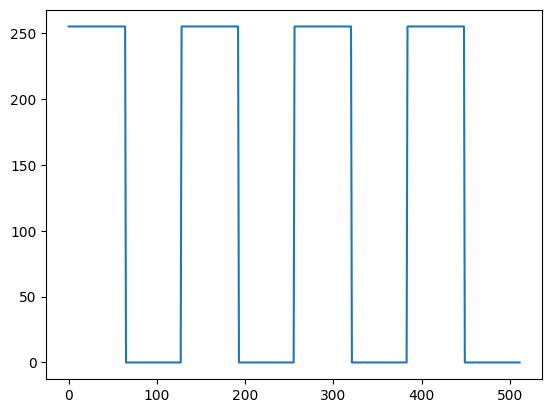

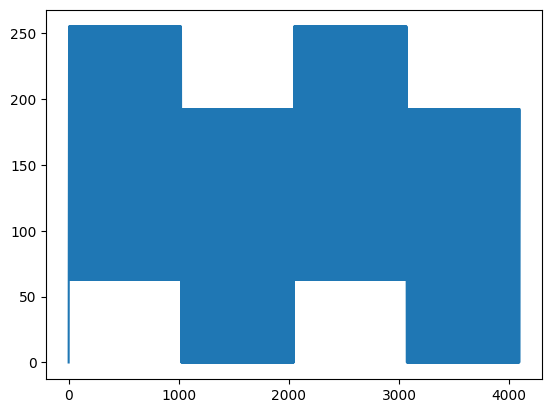

In [38]:
%matplotlib inline
plt.plot (marks[2])

plt.figure()
plt.plot (waves[1])

## Download wave-data and markers-data to segments

In [53]:
# Download segments

# data-type code: 'B' = uint8, 'H' = uint16
if dac_mode == 16:
    wav_dat_type = 'H'
else:
    wav_dat_type = 'B'
#wav_dat_type = 'H' if dac_mode == 16 else 'B'
mrk_dat_type = 'B'

ddr = num_channels if dac_mode == 8 else (num_channels/2)
print(ddr)

for jj in range(int(ddr)):
    channb = jj+1
    for ii in range(NumofSegments):

        segnum = 1 + ii
        wav = waves[ii]
        mrk = marks[ii]
        print('Download wave to segment {0} of channel {1}'.format(segnum, channb))

        # Select channel
        cmd = ':INST:CHAN {0}'.format(channb)
        inst.send_scpi_cmd(cmd)

        # Define segment
        cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
        inst.send_scpi_cmd(cmd) 
        
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
       # inst.write_binary_data('*OPC?; :TRAC:DATA', wav, datatype=wav_dat_type)
        cmd = ':TRAC:DATA {0}'.format(offset * offset_factor)
        inst.write_binary_data(cmd, wav)
        

        # Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000;

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))

        print('Download markers to segment {0} of channel {1}'.format(segnum, channb))

        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
        #inst.write_binary_data('*OPC?; :MARK:DATA', mrk, datatype=mrk_dat_type)
        cmd = '*OPC?; :MARK:DATA'
        inst.write_binary_data(cmd, mrk)
        

        #Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))


        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)    

        # Turn on the output of the selected channel:
        #cmd = ':OUTP ON'
        #pyte.send_cmd(inst, cmd, paranoia_level) 

        resp = inst.send_scpi_query(':SYST:ERR?')
        print(resp)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del waves
del wav


        

4
Download wave to segment 1 of channel 1
Download markers to segment 1 of channel 1
0, no error
Download wave to segment 2 of channel 1
Download markers to segment 2 of channel 1
0, no error
Download wave to segment 3 of channel 1
Download markers to segment 3 of channel 1
0, no error
Download wave to segment 4 of channel 1
Download markers to segment 4 of channel 1
0, no error
Download wave to segment 1 of channel 2
Download markers to segment 1 of channel 2
0, no error
Download wave to segment 2 of channel 2
Download markers to segment 2 of channel 2
0, no error
Download wave to segment 3 of channel 2
Download markers to segment 3 of channel 2
0, no error
Download wave to segment 4 of channel 2
Download markers to segment 4 of channel 2
0, no error
Download wave to segment 1 of channel 3
Download markers to segment 1 of channel 3
0, no error
Download wave to segment 2 of channel 3
Download markers to segment 2 of channel 3
0, no error
Download wave to segment 3 of channel 3
Download

In [13]:
print((waves))

[None, None, None, None]


## Load task table

In [56]:
tasklen = 6

for ii in range(num_channels):
    channb=ii+1
    #Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)

    
    cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
    inst.send_scpi_cmd(cmd)
    
    for jj in range(tasklen):
        curr_task = jj+1
        loop = jj+1
        segnb = jj+1
        cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
        inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:TYPE SING'
        inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:LOOP {0}'.format(loop)
        inst.send_scpi_cmd(cmd)
       
        cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
        inst.send_scpi_cmd(cmd)
       
        if curr_task==tasklen:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
            inst.send_scpi_cmd(cmd)
        else:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
            inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:WRIT'
    inst.send_scpi_cmd(cmd)
    print('Downloading Task table of channel {0}'.format(channb))
    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

 

0, no error
0, no error
0, no error
0, no error


## Switch to Task mode and turn on channel and marker outputs

In [57]:
for ii in range(num_channels):
    
    channb=ii+1
    
    cmd = ':INST:CHAN {0}'.format(channb)
    inst.send_scpi_cmd(cmd)
    
    cmd = ':OUTP ON'
    inst.send_scpi_cmd(cmd)

    cmd = 'FUNC:MODE TASK'
    inst.send_scpi_cmd(cmd)
    
    if dac_mode==16:
        
        for jj in range(2):
        
            mrk = jj+1
        
            cmd = ':MARK:SEL {0}'.format(mrk)
            inst.send_scpi_cmd(cmd)
        
            cmd = ':MARK ON'
            inst.send_scpi_cmd(cmd)
            
    elif dac_mode==8:
            
        for jj in range(4):

            mrk = jj+1

            cmd = ':MARK:SEL {0}'.format(mrk)
            inst.send_scpi_cmd(cmd)

            cmd = ':MARK ON'
            inst.send_scpi_cmd(cmd) 
            
        

## End

In [58]:
# close connection
inst.close_instrument()
print('closed session')

closed session
